# A ConvNet Recognizing Numbers in Sign Language

Build and train a ConvNet in Tensorflow for a classification problem. This model can recognize signs representing numbers from 0 to 5 with accuracy ~ 80%.

<img src="hands.png" style="width:800px;height:300px;">

In [1]:
# packages
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

## 1 - Load the dataset

In [2]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 0


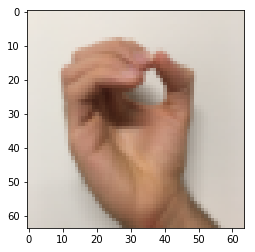

In [3]:
# Example of a picture
index = 1
plt.imshow(X_train_orig[index])
print("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [4]:
X_train = X_train_orig / 255.
X_test = Y_test_orig / 255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 1
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (1, 120)
Y_test shape: (120, 6)


## 2 - TensorFlow Model

### 2.1 - Create placeholders

In [5]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """
    
    X = tf.placeholder(tf.float32, (None, n_H0, n_W0, n_C0))
    Y = tf.placeholder(tf.float32, (None, n_y))
    
    return X, Y

### 2.2 - Initialize parameters

In [6]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Note that we will hard code the shape values in the function to make the grading simpler.
    Normally, functions should take values as inputs rather than hard coding.
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)
    
    parameters = {}
    parameters['W1'] = tf.get_variable('W1', [4, 4, 3, 8], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    parameters['W2'] = tf.get_variable('W2', [2, 2, 8, 16], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    
    return parameters

### 2.3 - Forward propagation

The structure of this model: `CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED`.

The functions we'll use:

- tf.nn.conv2d(X,W, strides = [1,s,s,1], padding = 'SAME')
- tf.nn.max_pool(A, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME')
- tf.nn.relu(Z)
- tf.contrib.layers.flatten(P)
- tf.contrib.layers.fully_connected(F, num_outputs)
    - Note: Do not call the softmax here. In TensorFlow, the softmax and cost function are lumped together into a single function.

In [7]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Note that for simplicity and grading purposes, we'll hard-code some values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    
    Z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding='SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize=[1,8,8,1], strides=[1,8,8,1], padding='SAME')
    Z2 = tf.nn.conv2d(P1, W2, strides=[1,1,1,1], padding='SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME')
    F = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(F, 6, activation_fn=None)
    
    return Z3

### 2.4 - Compute cost

The functions we'll use:

- **tf.nn.softmax_cross_entropy_with_logits(logits = Z, labels = Y):** computes the softmax entropy loss.
- **tf.reduce_mean():** computes the mean of elements across dimensions of a tensor.


In [8]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (number of examples, 6)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    
    return cost

### 2.5 - Build the model

Merge the functions above into a model.

In [9]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3
    
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            seed += 1
            epoch_cost = 0.
            num_minibatches = m // minibatch_size
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch_X, minibatch_Y in minibatches:
                _, tmp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                epoch_cost += tmp_cost / num_minibatches
            
            if print_cost and epoch % 5 == 0:
                print('Cost after iteration %i: %f' % (epoch, epoch_cost))
            if print_cost and epoch % 10 == 0:
                costs.append(cost)
    
    plt.plot(costs)
    plt.xlabel('iterations (per tens)')
    plt.ylabel('Cost')
    plt.title('Learning rate = ' + str(learning_rate))
    plt.show()
    
    # calculate accuracy
    correct_prediction = tf.equal(tf.argmax(Z3, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
    print('Train accuracy: ' + str(accuracy.eval({X:X_train, Y:Y_train})))
    print('Test accuracy: ' + str(accuracy.eval({X:X_test, Y:Y_test})))
    
    return parameters

Cost after iteration 0: 1.917929
Cost after iteration 5: 1.506757
Cost after iteration 10: 0.955359
Cost after iteration 15: 0.845802
Cost after iteration 20: 0.701174
Cost after iteration 25: 0.571977
Cost after iteration 30: 0.518435
Cost after iteration 35: 0.495806
Cost after iteration 40: 0.429827
Cost after iteration 45: 0.407291
Cost after iteration 50: 0.366394
Cost after iteration 55: 0.376922
Cost after iteration 60: 0.299491
Cost after iteration 65: 0.338870
Cost after iteration 70: 0.316400
Cost after iteration 75: 0.310413
Cost after iteration 80: 0.249549
Cost after iteration 85: 0.243457
Cost after iteration 90: 0.200031
Cost after iteration 95: 0.175452


ValueError: setting an array element with a sequence.

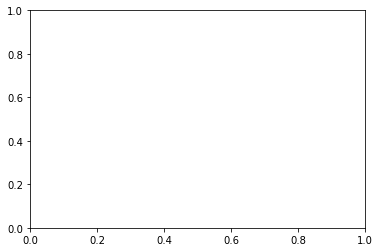

In [10]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)